<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/seed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/colab/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c superai-north-seed-detection

 99% 341M/344M [00:01<00:00, 251MB/s]
100% 344M/344M [00:01<00:00, 273MB/s]


In [ ]:
!unzip /content/superai-north-seed-detection.zip
!rm /content/superai-north-seed-detection.zip

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 10323, done.
remote: Counting objects: 100% (1168/1168), done.
remote: Compressing objects: 100% (774/774), done.
remote: Total 10323 (delta 651), reused 682 (delta 382), pack-reused 9155
Receiving objects: 100% (10323/10323), 6.87 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (6845/6845), done.


In [ ]:
import os
os.chdir('/content/ultralytics')

In [ ]:
!pwd

/content/ultralytics


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ultralytics
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ultralytics


In [ ]:
from ultralytics import RTDETR

model = RTDETR("rtdetr-l.pt")

100%|██████████| 63.4M/63.4M [00:00<00:00, 72.9MB/s]


In [ ]:

from tqdm.notebook import tqdm,trange
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import pandas as pd

In [ ]:
import json
f = open('/content/boundarybox_seed_train.json')
data = json.load(f)
for _ in data :
    print(_)

info
images
annotations
categories


In [ ]:
# width , height
width,height = data['images'][0]['width'],data['images'][0]['height']
print(' width :',width,'\n','height :',height)

label_id = {}
for _ in data['images'] :
    label_id[_['id']] = _['file_name']
label_id


In [ ]:
label_seed = {}
for _ in data['categories'] :
    label_seed [_['id']] = _['name']
label_seed

{1: 'adenanthera_pavonina',
 2: 'alangium_kurzii',
 3: 'albizia_chinensis',
 4: 'antidesma_bunius',
 5: 'bridelia_glauca',
 6: 'cassia_bakeriana',
 7: 'cassia_fistula',
 8: 'cassia_grandis',
 9: 'choerospondias_axillaris',
 10: 'delbergia_oliveri',
 11: 'drypetes_roxburghii',
 12: 'hovenia_dulcis',
 13: 'magnolia_baillonii',
 14: 'ostodes_paniculata',
 15: 'phyllanthus_emblica',
 16: 'prunus_cerasoides',
 17: 'rhus_rhetsoides',
 18: 'sapindus_rarak',
 19: 'trewia_nudiflora',
 20: 'turpinia_pomifera'}

In [ ]:
df =pd.DataFrame(data['annotations'])
df.drop(columns=['id','iscrowd','segmentation','area'],inplace=True)
df['image_id']=df['image_id'].replace(label_id)

df['fold'] =0
fold = 1
for i in range(len(df)):
    if i!=0 :
        if df['image_id'][i] != df['image_id'][i-1] :
            fold += 1
    if fold ==6 :
        fold =1
    df['fold'][i] = fold

df


<ipython-input-15-d0ab19167464>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fold'][i] = fold


image_id  category_id                                               bbox  \
0    001.jpg            1  [1662.8450902273253, 673.2599015701896, 320.59...   
1    001.jpg            1  [2018.71103820014, 926.5338645418324, 323.8059...   
2    001.jpg            1  [1961.0030466369808, 1304.8418092336533, 304.5...   
3    001.jpg            1  [1486.5151160065614, 1567.7337707991558, 307.7...   
4    001.jpg            1  [1656.433091164752, 1288.8118115772202, 294.95...   
..       ...          ...                                                ...   
992  095.jpg           20  [2225.019920318724, 1394.1035856573699, 269.64...   
993  095.jpg           20  [1989.800796812748, 1434.2629482071707, 246.69...   
994  095.jpg           20  [1751.7131474103578, 1534.6613545816726, 246.6...   
995  095.jpg           20  [1496.4143426294813, 1465.8167330677284, 266.7...   
996  095.jpg           20  [1450.5179282868519, 1744.0637450199197, 324.1...   

     fold  
0       1  
1       1  
2       1  
3       1  
4       1  
..    ...  
992     5  
993     5  
994     5  
995     5  
996     5  

[997 rows x 4 columns]

In [ ]:
# split 80 : 20 follow category and group by image
df_train =df[df['fold']!=5].reset_index(drop=True)
df_val = df[df['fold']==5].reset_index(drop=True)

len(df_train),len(df_val)

(797, 200)

3648 2736
((1824.9083665338637, 975.5856573705175), (2105.593625498007, 1264.4462151394416))


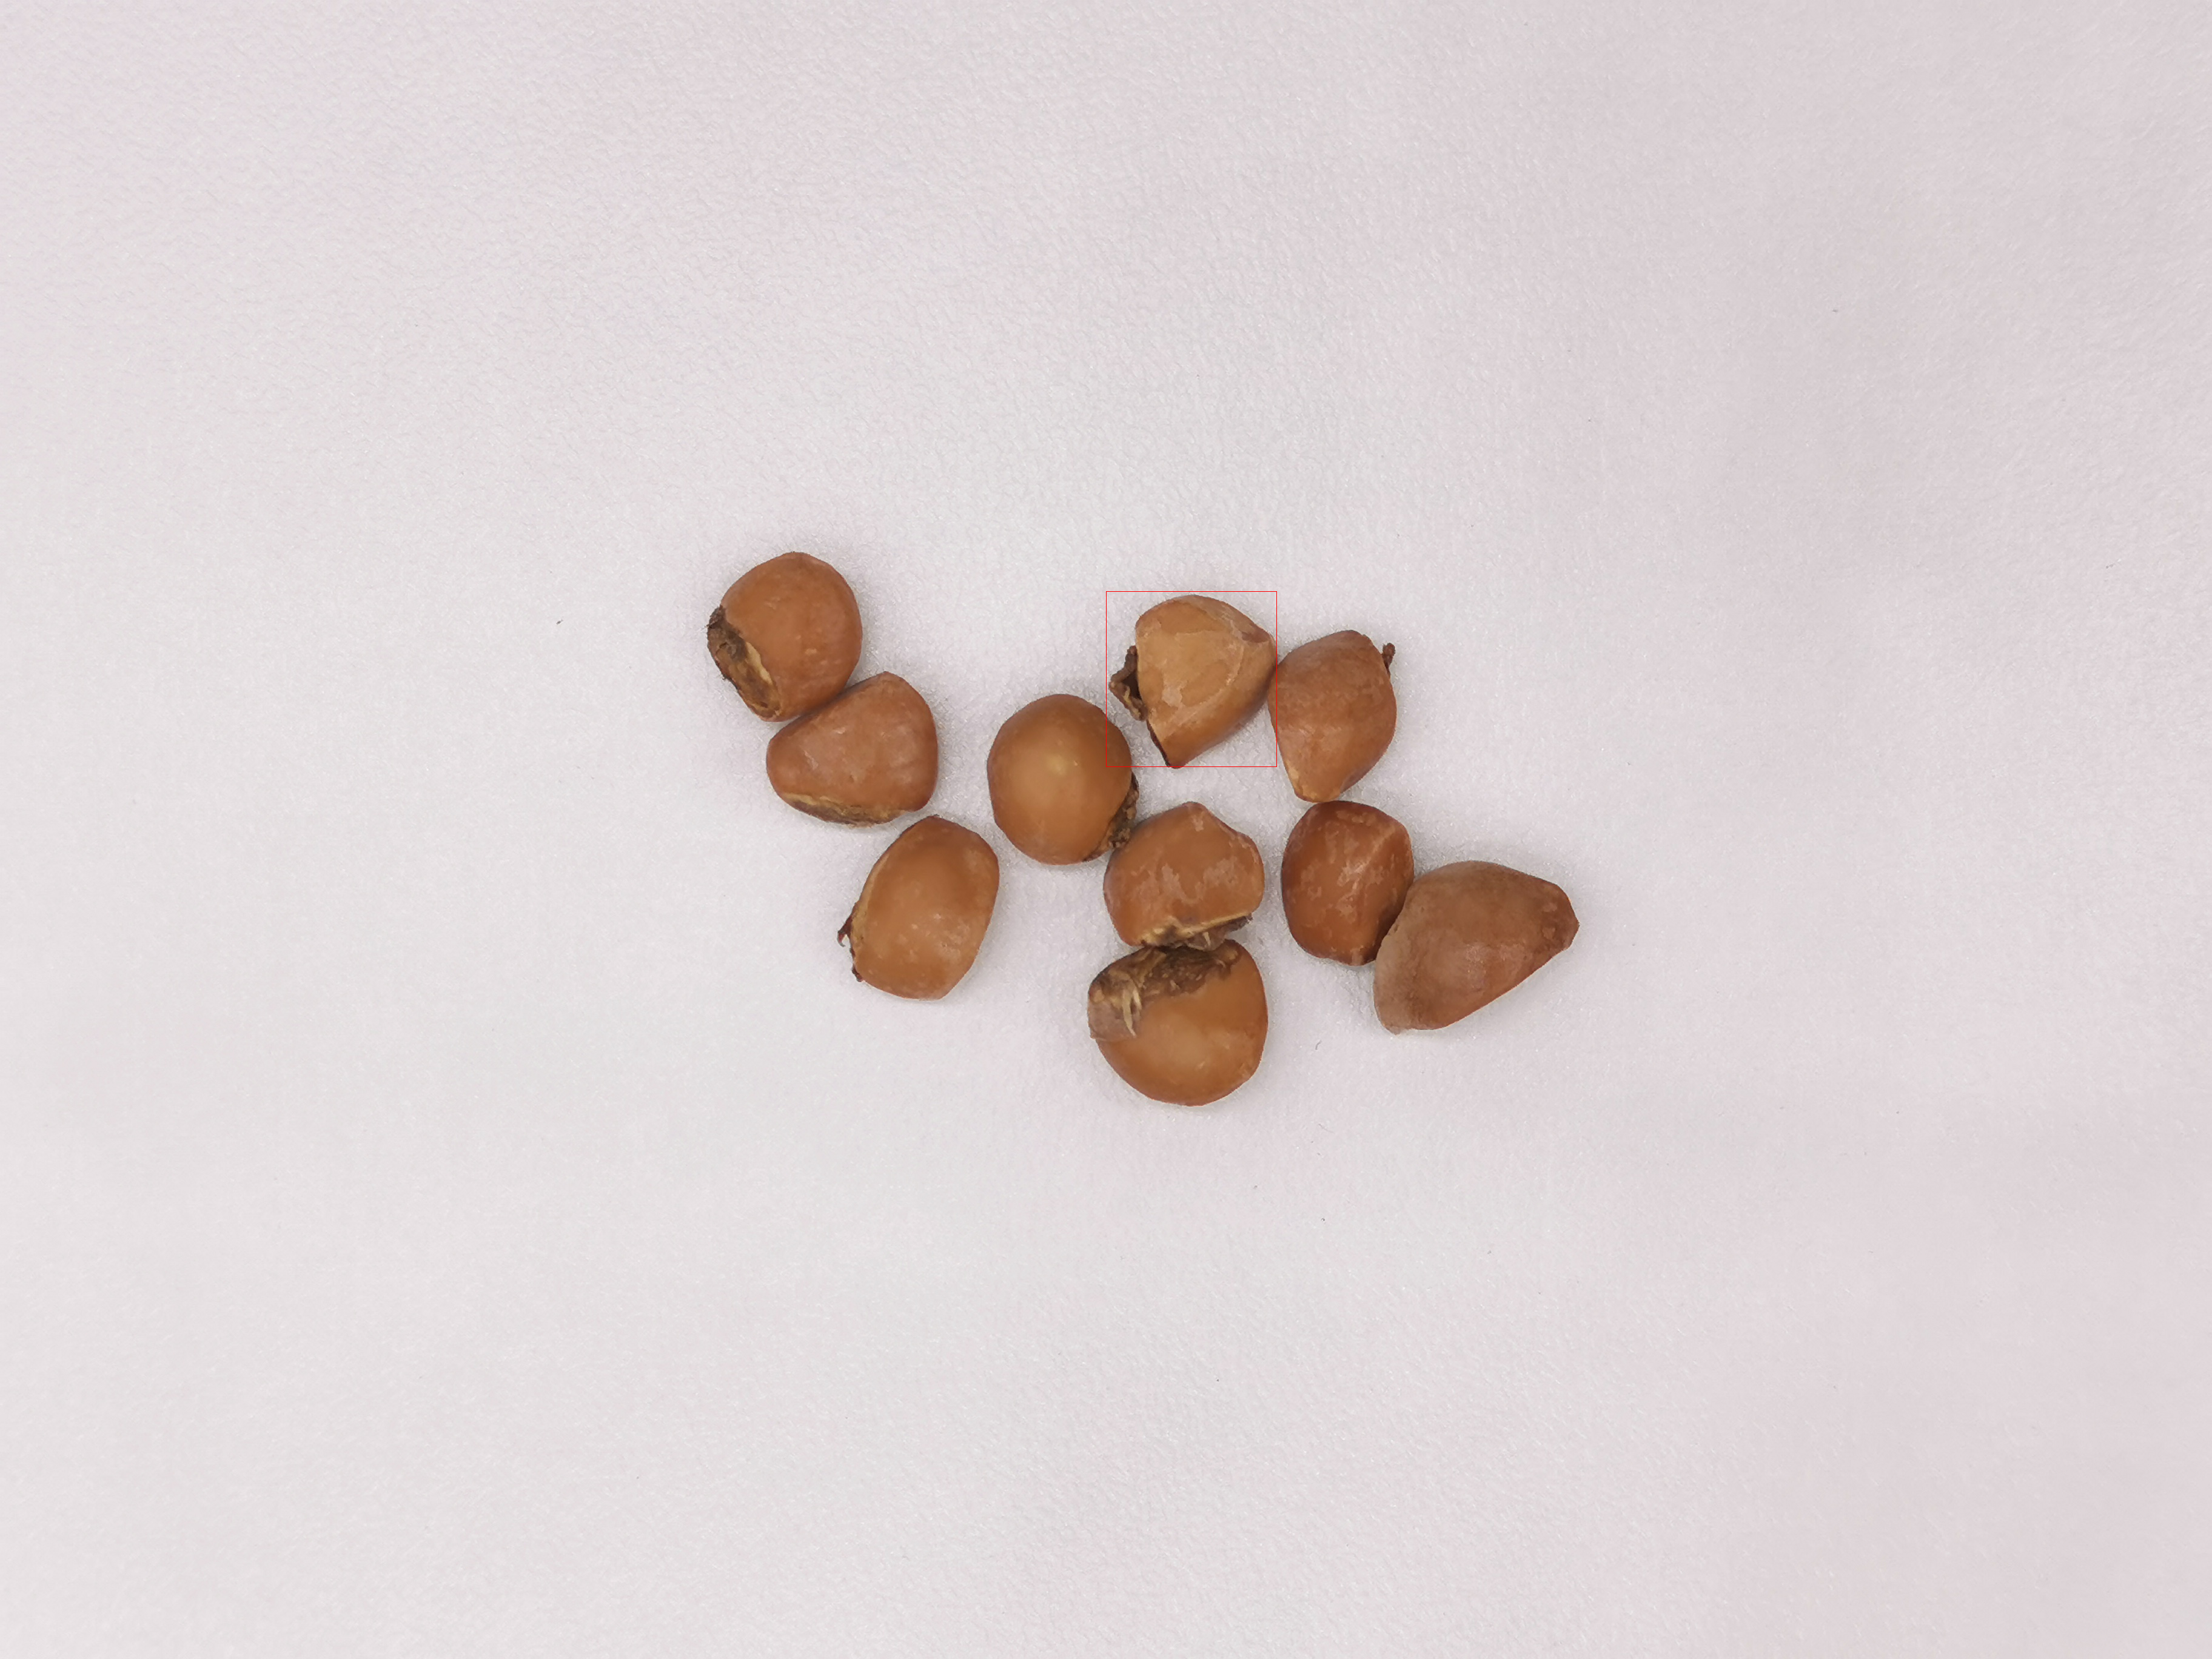

In [ ]:
from PIL import Image, ImageDraw

index=796
name = df_train['image_id'][index]
img = Image.open(rf'/content/train/{name}')
f= df_train['bbox'][index]
w,h =img.size
print(w,h)
shape = ((f[0], f[1]), (f[0]+f[2],f[1]+f[3]))  # coco
print(shape)



draw = ImageDraw.Draw(img)
draw.rectangle(shape, outline ="red")

img

In [ ]:
!rm -rf /content/doc
!mkdir /content/doc
!mkdir /content/doc/images
!mkdir /content/doc/images/train
!mkdir /content/doc/images/val
!mkdir /content/doc/labels
!mkdir /content/doc/labels/train
!mkdir /content/doc/labels/val

In [ ]:
import shutil

path_old = '/content/train/'
path_new = '/content/doc/images/'
def create_data(df,mode='train') :
    list_image = df['image_id'].unique().tolist()

    for image_ in list_image:
        '''copy image'''
        shutil.copy(path_old+image_, path_new+mode+'/'+image_)

        '''create txt'''
        #query image
        df_ = df[df['image_id']==image_].reset_index(drop=True)
        name = image_[:-4]
        with open(f'/content/doc/labels/{mode}/{name}.txt', 'w') as f:
            for i in range(len(df_)):
                f.write(f"{df_['category_id'][i]} {(df_['bbox'][i][0]+df_['bbox'][i][2]/2)/w} {(df_['bbox'][i][1]+df_['bbox'][i][3]/2)/h} {df_['bbox'][i][2]/w} {df_['bbox'][i][3]/h}\n")


create_data(df_train,mode='train')
create_data(df_val,mode='val')

In [ ]:
!gdown 1tcv5vAf4rRCgK5d8piGNQ7xsatLJQ0Lk
!mv /content/ultralytics/seed_detection.yaml /content/doc/seed_detection.yaml

Downloading...
From: https://drive.google.com/uc?id=1tcv5vAf4rRCgK5d8piGNQ7xsatLJQ0Lk
To: /content/ultralytics/seed_detection.yaml
100% 597/597 [00:00<00:00, 3.76MB/s]


In [ ]:
#structure
'''
doc
|
|---seed_detection.yaml
|
|---images
    |
    |--train
    |--val
|
|---labels
    |
    |--train
    |--val

'''
print('')

In [ ]:
from ultralytics import RTDETR

model = RTDETR("rtdetr-l.pt")

In [ ]:
# ส่วนการเทรนโมเดล ในกรณีที่ไม่มีไฟล์ coco128.yaml ระบบจะโหลดให้เช่นกัน แต่ต้องแก้ไข
model.train(
    data = "/content/doc/seed_detection.yaml", #
    epochs = 100,
#     imgsz=(w/4,h/4) ,
    batch = -1, # -1 ตั้งค่า Batch size อัตโนมัติ

#     agnostic_nms = True ,
#     cos_lr = True ,
#     augment = True,

#     hsv_h = 0.015 ,
#     hsv_s = 0.7 ,
#     hsv_v = 0.4 ,
#     degrees = 0.4,
#     translate = 0.3,
#     scale = 0.5,
#     shear = 0.01,
#     flipud = 0.3,
#     fliplr =0.5,
#     mixup = 0.5,

    # ตัวแปรเพิ่มเติม: https://docs.ultralytics.com/modes/train/#arguments

    #https://github.com/ultralytics/ultralytics/issues/2412#issuecomment-1564232587
    )

Ultralytics YOLOv8.0.118 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=None, data=/content/doc/seed_detection.yaml, epochs=100, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=False, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dyna

In [ ]:
!cp /content/ultralytics/runs/detect/train2/weights/best.pt /content/drive/MyDrive/Colab_Notebooks/Hank_sp/Seed_detection/best.pt

NotImplementedError: ignored

In [ ]:
model_yolo_v8 = RTDETR('/content/ultralytics/runs/detect/train2/weights/best.pt')


image 1/1 /content/test/120.jpg: 640x640 2 alangium_kurziis, 3 antidesma_buniuss, 2 trewia_nudifloras, 2 turpinia_pomiferas, 120.3ms
Speed: 5.3ms preprocess, 120.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/ultralytics/runs/detect/predict


turpinia_pomifera 0.5969517230987549
turpinia_pomifera 0.6769682765007019
alangium_kurzii 0.9161413311958313
antidesma_bunius 0.911063015460968
antidesma_bunius 0.917651355266571
alangium_kurzii 0.9163905382156372
antidesma_bunius 0.9187690615653992
trewia_nudiflora 0.8913200497627258
trewia_nudiflora 0.7965468764305115
9


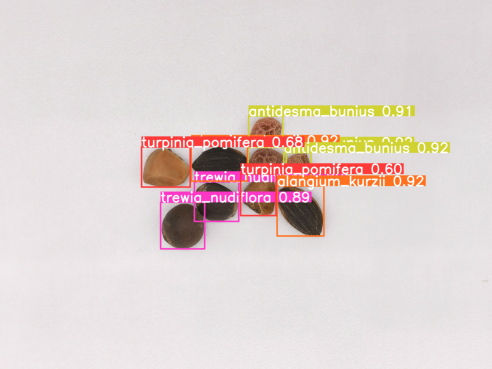

In [ ]:
image_path='/content/test/120.jpg'
pred = model_yolo_v8.predict(image_path, conf=0.25,max_det=100)[0]


res_plotted = pred.plot()

plt.axis(False)
plt.rcParams['savefig.pad_inches'] = 0
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

result_label=[]
for idx,prob in zip(pred.boxes.cls.tolist(),pred.boxes.conf.tolist()) :
    if len(pred.boxes.cls.tolist()) >10 :
        if prob >0.2 :
            result_label.append(label_seed[int(idx)])
            print(label_seed[int(idx)],prob)

    else:
        result_label.append(label_seed[int(idx)])
        print(label_seed[int(idx)],prob)
print(len(result_label))

In [ ]:
df_sub = pd.read_csv('/content/sample_submission.csv')
df_sub

id  rhus_rhetsoides  cassia_bakeriana  albizia_chinensis  \
0   101.jpg              NaN               NaN                NaN   
1   102.jpg              NaN               NaN                NaN   
2   103.jpg              NaN               NaN                NaN   
3   104.jpg              NaN               NaN                NaN   
4   105.jpg              NaN               NaN                NaN   
..      ...              ...               ...                ...   
95  196.jpg              NaN               NaN                NaN   
96  197.jpg              NaN               NaN                NaN   
97  198.jpg              NaN               NaN                NaN   
98  199.jpg              NaN               NaN                NaN   
99  200.jpg              NaN               NaN                NaN   

    cassia_grandis  magnolia_baillonii  delbergia_oliveri  prunus_cerasoides  \
0              NaN                 NaN                NaN                NaN   
1              NaN                 NaN                NaN                NaN   
2              NaN                 NaN                NaN                NaN   
3              NaN                 NaN                NaN                NaN   
4              NaN                 NaN                NaN                NaN   
..             ...                 ...                ...                ...   
95             NaN                 NaN                NaN                NaN   
96             NaN                 NaN                NaN                NaN   
97             NaN                 NaN                NaN                NaN   
98             NaN                 NaN                NaN                NaN   
99             NaN                 NaN                NaN                NaN   

    alangium_kurzii  adenanthera_pavonina  ...  phyllanthus_emblica  \
0               NaN                   NaN  ...                  NaN   
1               NaN                   NaN  ...                  NaN   
2               NaN                   NaN  ...                  NaN   
3               NaN                   NaN  ...                  NaN   
4               NaN                   NaN  ...                  NaN   
..              ...                   ...  ...                  ...   
95              NaN                   NaN  ...                  NaN   
96              NaN                   NaN  ...                  NaN   
97              NaN                   NaN  ...                  NaN   
98              NaN                   NaN  ...                  NaN   
99              NaN                   NaN  ...                  NaN   

    ostodes_paniculata  sapindus_rarak  trewia_nudiflora  \
0                  NaN             NaN               NaN   
1                  NaN             NaN               NaN   
2                  NaN             NaN               NaN   
3                  NaN             NaN               NaN   
4                  NaN             NaN               NaN   
..                 ...             ...               ...   
95                 NaN             NaN               NaN   
96                 NaN             NaN               NaN   
97                 NaN             NaN               NaN   
98                 NaN             NaN               NaN   
99                 NaN             NaN               NaN   

    choerospondias_axillaris  antidesma_bunius  drypetes_roxburghii  \
0                        NaN               NaN                  NaN   
1                        NaN               NaN                  NaN   
2                        NaN               NaN                  NaN   
3                        NaN               NaN                  NaN   
4                        NaN               NaN                  NaN   
..                       ...               ...                  ...   
95                       NaN               NaN                  NaN   
96                       NaN               NaN                  NaN   
97    

In [ ]:
predict_list =df_sub.columns.tolist()[1:]
for i_ in trange(len(df_sub)):
    image_path=f"/content/test/{df_sub['id'][i_]}"
    pred = model_yolo_v8.predict(image_path, conf=0.25,max_det=100)[0]

    result_label=[]
    for idx,prob in zip(pred.boxes.cls.tolist(),pred.boxes.conf.tolist()) :
        if len(pred.boxes.cls.tolist()) >10 :
            if prob >0.42 :
                result_label.append(label_seed[int(idx)])
        else:
            result_label.append(label_seed[int(idx)])

        count_label=pd.DataFrame(result_label).value_counts()
        for name_ in predict_list :
            if name_ in result_label :
                df_sub.loc[i_,name_]=count_label[name_]
            else :
                df_sub.loc[i_,name_]=int(0)

  0%|          | 0/100 [00:00<?, ?it/s]


image 1/1 /content/test/101.jpg: 640x640 3 adenanthera_pavoninas, 2 cassia_bakerianas, 3 cassia_fistulas, 2 delbergia_oliveris, 132.0ms
Speed: 5.3ms preprocess, 132.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/ultralytics/runs/detect/predict

image 1/1 /content/test/102.jpg: 640x640 3 adenanthera_pavoninas, 1 alangium_kurzii, 2 antidesma_buniuss, 2 prunus_cerasoidess, 2 turpinia_pomiferas, 135.1ms
Speed: 4.9ms preprocess, 135.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/ultralytics/runs/detect/predict

image 1/1 /content/test/103.jpg: 640x640 3 adenanthera_pavoninas, 1 cassia_bakeriana, 1 trewia_nudiflora, 5 turpinia_pomiferas, 97.8ms
Speed: 5.3ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/ultralytics/runs/detect/predict

image 1/1 /content/test/104.jpg: 640x640 5 adenanthera_pavoninas, 1 cassia_bakeriana, 1 delbergia_ol

In [ ]:
df_sub

id  rhus_rhetsoides  cassia_bakeriana  albizia_chinensis  \
0   101.jpg              0.0               2.0                0.0   
1   102.jpg              0.0               0.0                0.0   
2   103.jpg              0.0               1.0                0.0   
3   104.jpg              0.0               1.0                0.0   
4   105.jpg              0.0               0.0                0.0   
..      ...              ...               ...                ...   
95  196.jpg              0.0               0.0                0.0   
96  197.jpg              0.0               0.0                0.0   
97  198.jpg              0.0               0.0                0.0   
98  199.jpg              0.0               0.0                0.0   
99  200.jpg              0.0               0.0                0.0   

    cassia_grandis  magnolia_baillonii  delbergia_oliveri  prunus_cerasoides  \
0              0.0                 0.0                2.0                0.0   
1              0.0                 0.0                0.0                2.0   
2              0.0                 0.0                0.0                0.0   
3              0.0                 0.0                1.0                0.0   
4              0.0                 0.0                1.0                2.0   
..             ...                 ...                ...                ...   
95             0.0                 0.0                0.0                0.0   
96             0.0                 1.0                0.0                0.0   
97             2.0                 0.0                2.0                1.0   
98             0.0                 0.0                0.0                0.0   
99             0.0                 0.0                0.0                2.0   

    alangium_kurzii  adenanthera_pavonina  ...  phyllanthus_emblica  \
0               0.0                   3.0  ...                  0.0   
1               1.0                   3.0  ...                  0.0   
2               0.0                   3.0  ...                  0.0   
3               0.0                   5.0  ...                  0.0   
4               0.0                   4.0  ...                  0.0   
..              ...                   ...  ...                  ...   
95              0.0                   0.0  ...                  0.0   
96              0.0                   0.0  ...                  0.0   
97              0.0                   0.0  ...                  0.0   
98              0.0                   0.0  ...                  0.0   
99              1.0                   2.0  ...                  0.0   

    ostodes_paniculata  sapindus_rarak  trewia_nudiflora  \
0                  0.0             0.0               0.0   
1                  0.0             0.0               0.0   
2                  0.0             0.0               1.0   
3                  2.0             0.0               0.0   
4                  0.0             0.0               0.0   
..                 ...             ...               ...   
95                 2.0             1.0               0.0   
96                 0.0             1.0               2.0   
97                 0.0             0.0               0.0   
98                 0.0             0.0               0.0   
99                 0.0             0.0               0.0   

    choerospondias_axillaris  antidesma_bunius  drypetes_roxburghii  \
0                        0.0               0.0                  0.0   
1                        0.0               2.0                  0.0   
2                        0.0               0.0                  0.0   
3                        0.0               0.0                  0.0   
4                        0.0               0.0                  0.0   
..                       ...               ...                  ...   
95                       0.0               0.0                  0.0   
96                       2.0               0.0                  0.0   
97    

In [ ]:
df_sub.to_csv('submission_rtdetr-l(42).csv',index=False)